# Medical Charges ---- AutoML-Regression

Di notebook ini, saya akan mencoba menentukan model terbaik untuk memprediksi biaya medis menggunakan AutoML tepatnya menggunakan Tree-Based Pipeline Optimization Tool (TPOT). 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import plot_confusion_matrix

from mlxtend.plotting import plot_learning_curves
from tpot import TPOTRegressor
from IPython.display import Image

In [2]:
med = pd.read_csv('insurance.csv')

In [3]:
med.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
pd.DataFrame({'dataFeatures' : med.columns, 'dataType' : med.dtypes.values, 
              'null' : [med[i].isna().sum() for i in med.columns],
              'nullPct' : [((med[i].isna().sum()/len(med[i]))*100).round(2) for i in med.columns],
             'Nunique' : [med[i].nunique() for i in med.columns],
             'uniqueSample' : [list(pd.Series(med[i].unique()).sample(2)) for i in med.columns]}).reset_index(drop = True)

,dataFeatures,dataType,null,nullPct,Nunique,uniqueSample
0,age,int64,0,0.0,47,"[30, 59]"
1,sex,object,0,0.0,2,"[female, male]"
2,bmi,float64,0,0.0,548,"[49.06, 23.76]"
3,children,int64,0,0.0,6,"[4, 5]"
4,smoker,object,0,0.0,2,"[yes, no]"
5,region,object,0,0.0,4,"[northeast, southwest]"
6,charges,float64,0,0.0,1337,"[2534.39375, 12495.29085]"


In [5]:
med.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [6]:
med.describe(exclude = np.number)

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


In [7]:
categorical = med.select_dtypes('object').columns
numerical = med.drop(categorical, axis = 1).columns
categorical, numerical

(Index(['sex', 'smoker', 'region'], dtype='object'),
 Index(['age', 'bmi', 'children', 'charges'], dtype='object'))

# Exploratory Data Analysis

## Correlation Analysis

In [8]:
#Correlation measurement untuk data discrete dan continous
def correlation_ratio(categories, measurement):
    fcat,_ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0, cat_num):
        cat_measures = measurement[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array, y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurement,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

#Correlation measurement untuk data discrete dan discrete
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

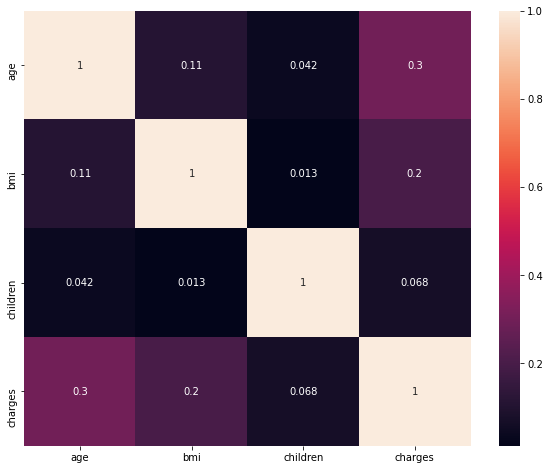

In [9]:
plt.figure(figsize = (10,8))
sns.heatmap(med.corr(), annot = True)

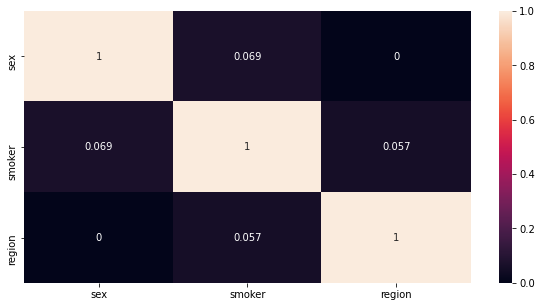

In [10]:
corrCat = []

for i in categorical:
    mat = []
    for j in categorical:
        mat.append(cramers_v(med[i],med[j]))
    corrCat.append(mat)
    
dfcramers = pd.DataFrame(corrCat, index = categorical, columns = categorical)
plt.figure(figsize = (10,5))
sns.heatmap(dfcramers,annot = True)

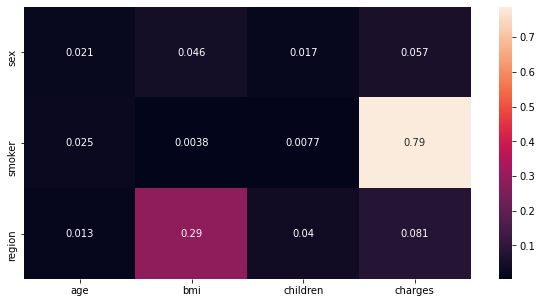

In [11]:
corrNumCat = []

for i in categorical:
    mat2 = []
    for j in numerical:
        mat2.append(correlation_ratio(med[i],med[j]))
    corrNumCat.append(mat2)
    
dfcramers = pd.DataFrame(corrNumCat, index = categorical, columns = numerical)
plt.figure(figsize = (10,5))
sns.heatmap(dfcramers,annot = True)

Masuk akal jika perokok atau tidak menentukan biaya kesehatannya. Dan pada dataset ini saya pikir, tidak terdapat multicolinearity. Dalam dataset ini, saya tidak akan menggunakan semua fitur. Saya hanya akan menggunakan fitur-fitur yang punya korelasi dengan fitur targetnya yaitu <i>charges</i>. 

## Target

Text(0.5, 1.0, 'Charges Distribution')

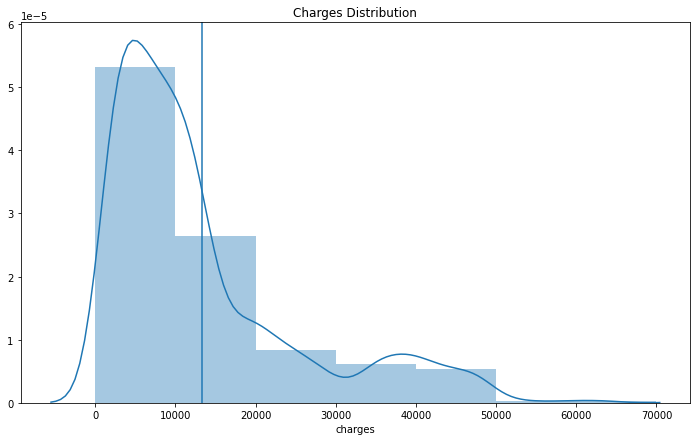

In [39]:
plt.figure(figsize = (12,7))
sns.distplot(med['charges'], bins = [0, 10000, 20000, 30000, 40000, 50000, 60000, 70000])
plt.axvline(med['charges'].mean())
plt.title('Charges Distribution')

Target tidak terlihat imbalanced, kebanyakan biayanya berada di sekitar 0 sampai 10000. 

## BMI

Menurut WHO, terdapat enam klasifikasi jika kita membicarakan BMI yaitu:

1. Underweight jika BMI < 18.5
2. Normal weight jika BMI di antara 18.5 dan 24.9
3. Overweight jika BMI  di antara 25.0 dan 29.9
4. Class I obesity  jika BMI di antara 30 dan 34.9
5. Class II obesity  jika BMI di antara 35.0 dan 39.9 
6. Class III obesity jika BMI >= 40

Source : https://en.wikipedia.org/wiki/Classification_of_obesity#cite_note-16

30.663396860986538


Text(0.5, 1.0, 'BMI Distribution')

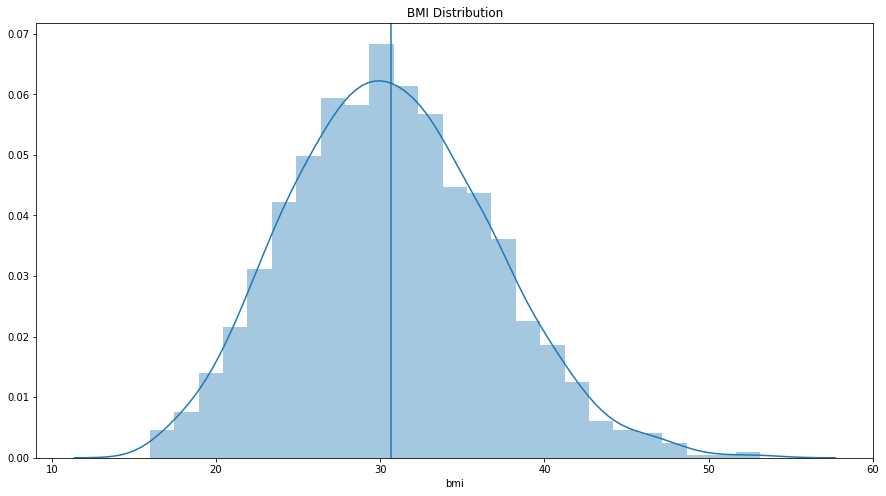

In [29]:
plt.figure(figsize = (15, 8))
sns.distplot(med['bmi'])
plt.axvline(med['bmi'].mean())
print(med['bmi'].mean())
plt.title('BMI Distribution')

Rata-rata orang di dataset ini punya BMI 30.66 dimana artinya, orang-orang di dataset ini rata-rata masuk dalam kategori obesitas. 

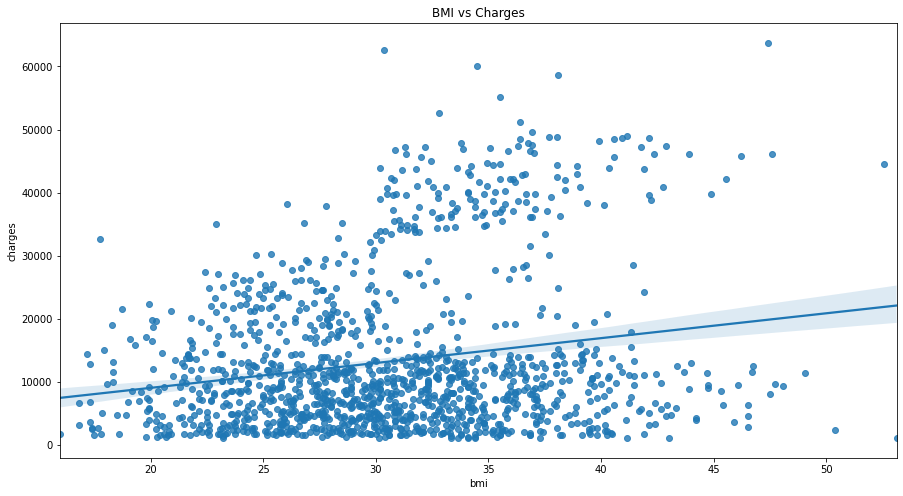

In [30]:
plt.figure(figsize = (15, 8))
plt.title('BMI vs Charges')
sns.regplot(med['bmi'], med['charges'])

Memang dari analisa korelasi di atas, sudah terlihat bahwa bmi memiliki korelasi terhadap biaya kesehatan. Namun dari visualisasi di atas, kita juga dapat melihat gradient dari garisnya tidak terlalu curam. 

In [41]:
med['bmi range'] = pd.cut(med['age'],[0, 18.5, 24.9, 29.9, 34.9, 39.9, 54])
med.groupby(['bmi range']).mean()['charges']

bmi range
(0.0, 18.5]      7086.217556
(18.5, 24.9]     9646.907162
(24.9, 29.9]     9524.780741
(29.9, 34.9]    11223.892815
(34.9, 39.9]    12282.509333
(39.9, 54.0]    15236.131504
Name: charges, dtype: float64

Terlihat bahwa semakin besar BMInya juga semakin besar juga biaya medisnya. 

## age

Text(0.5, 1.0, 'Age vs Charges')

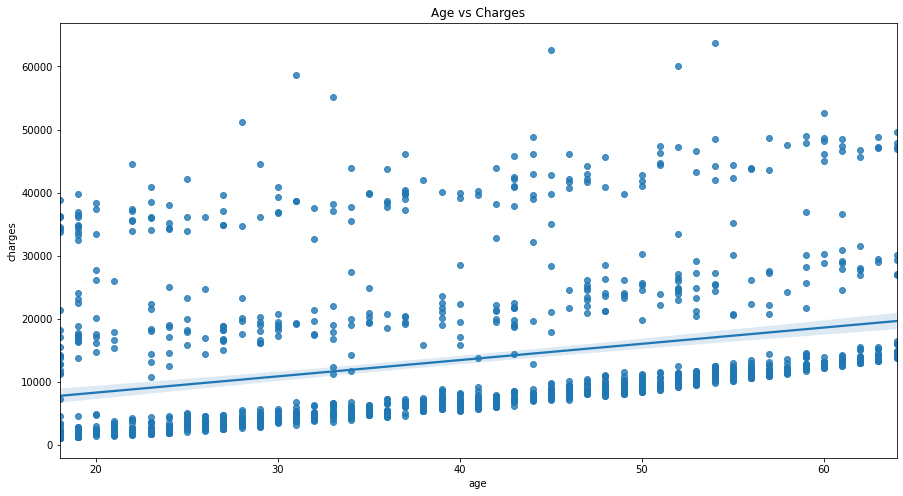

In [31]:
plt.figure(figsize = (15, 8))
sns.regplot(med['age'], med['charges'])
plt.title('Age vs Charges')

In [15]:
med['age range'] = pd.cut(med['age'],[17, 30, 40, 50, 60, 65])
med.groupby(['age range']).mean()['charges']

age range
(17, 30]     9397.552051
(30, 40]    11639.308653
(40, 50]    14782.043077
(50, 60]    17062.292763
(60, 65]    21063.163398
Name: charges, dtype: float64

Dapat dilihat, bahwa semakin tua umur seseorang, semakin mahal juga biaya medisnya. 

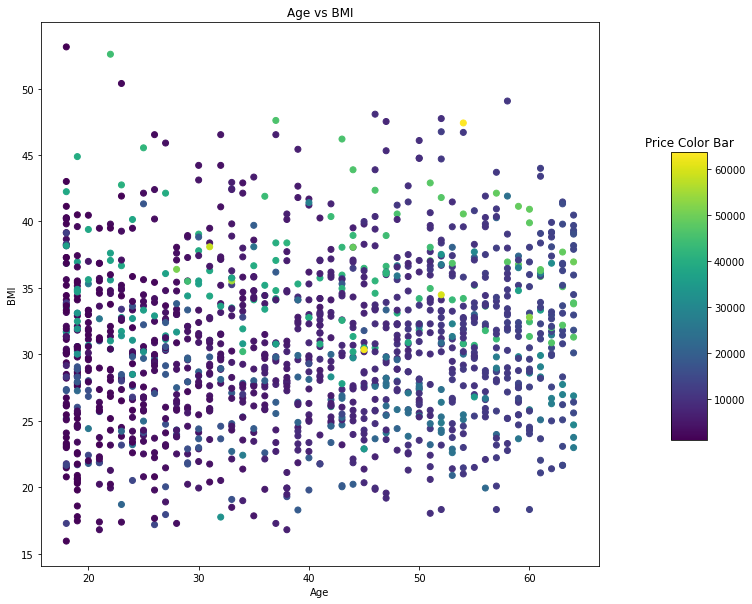

In [16]:
fig = plt.figure(figsize = (10,10))


plt.scatter(x = med['age'], y = med['bmi'],  c = med['charges'])

plt.xlabel("Age")
plt.ylabel("BMI")
plt.title("Age vs BMI")

# Adding colorbar
ax_col = fig.add_axes([1, 0.3, 0.05, 0.4])
ax_col.set_title('Price Color Bar')
plt.colorbar(cax = ax_col)

plt.show() 

Tidak terlihat adanya yang signifikan dari visualisasi di atas. 

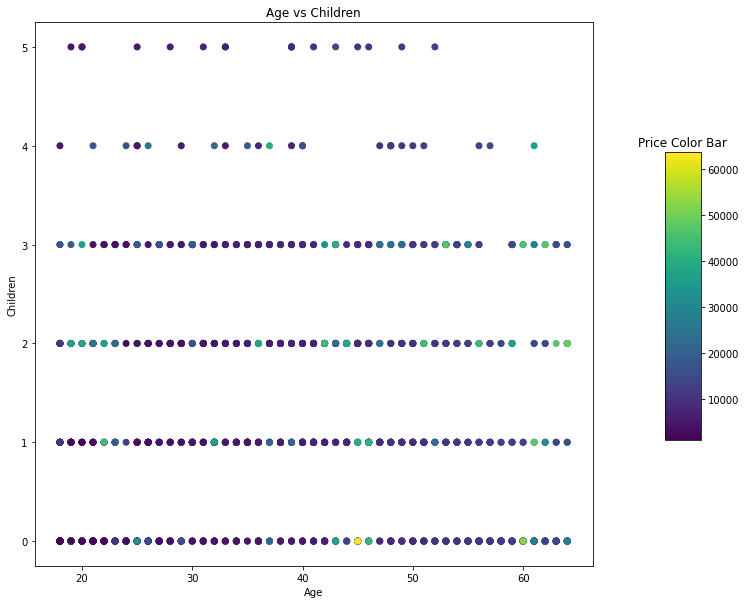

In [17]:
fig = plt.figure(figsize = (10,10))


plt.scatter(x = med['age'], y = med['children'],  c = med['charges'])

plt.xlabel("Age")
plt.ylabel("Children")
plt.title("Age vs Children")

# Adding colorbar
ax_col = fig.add_axes([1, 0.3, 0.05, 0.4])
ax_col.set_title('Price Color Bar')
plt.colorbar(cax = ax_col)

plt.show()

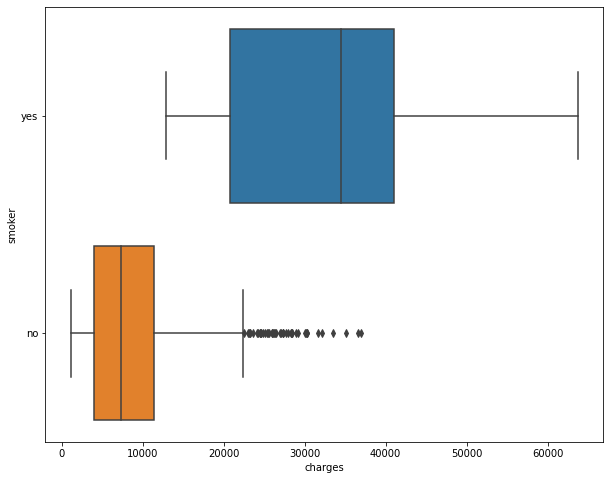

In [19]:
plt.figure(figsize = (10, 8))
sns.boxplot(med['charges'], med['smoker'])

Terlihat bahwa orang-orang yang tidak merokok memiliki biaya medis lebih sedikit daripada orang yang tidak merokok. Dan juga biaya medis orang yang merokok lebih bervariasi daripada orang yang tidak merokok. Seakan menunjukkan orang-orang yang merokok perawatannya atau penyakitnya lebih bervariasi.

# Tree-Based Pipeline Optimization Tool (TPOT)

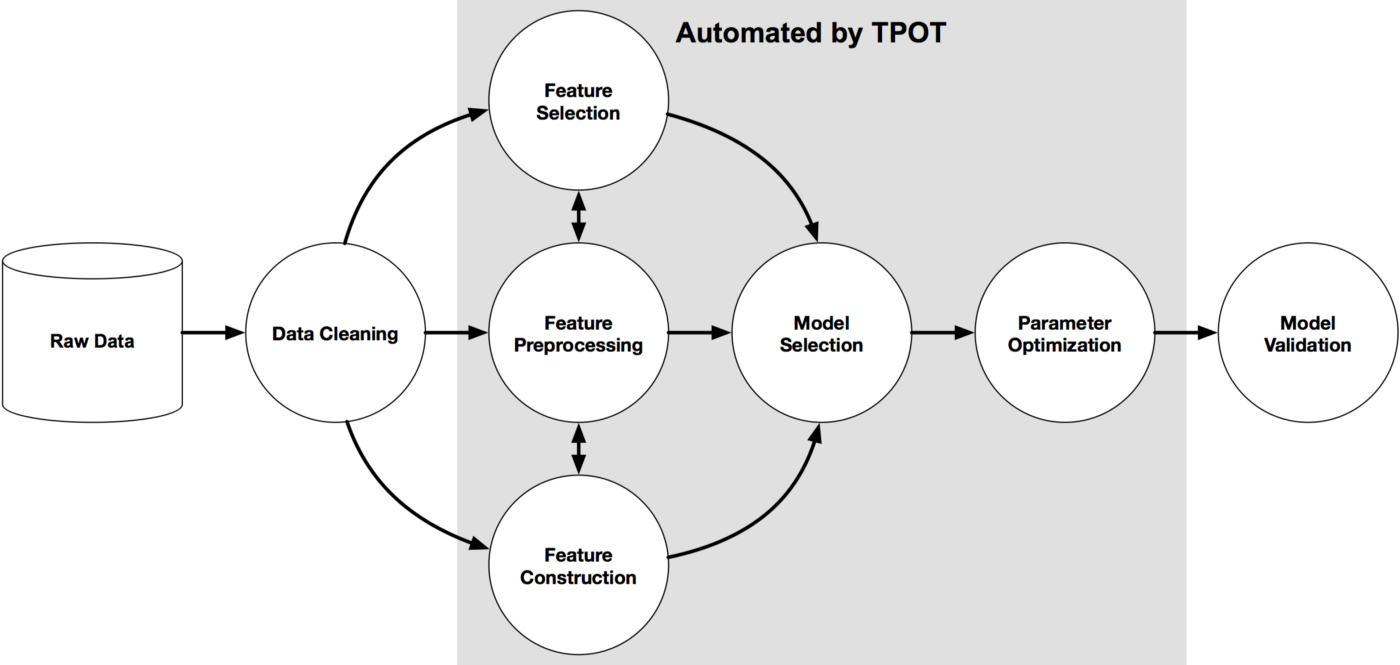

In [22]:
Image(filename='tpot.png', width = 1000, height = 1500)

source : http://epistasislab.github.io/tpot/

Dari gambar di atas, dapat dilihat bahwa sebetulnya yang perlu kita lakukan hanyalah membersihkan data dan melakukan evaluasi. Sisanya biar TPOT yang mengerjakannya. 

In [12]:
X = med[['smoker', 'age', 'bmi']]
y = med['charges']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1070, 3), (268, 3), (1070,), (268,))

In [14]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

Dikarenakan dataset relatif sedikit, saya pikir 20 menit cukup. 

In [10]:
tpot = TPOTRegressor(subsample = 0.8, verbosity = 2, warm_start = True, early_stop = 20, max_time_mins = 20, n_jobs = -1,
                    scoring = 'r2')

tpot.fit(X_train, y_train)

Generation 1 - Current best internal CV score: 0.846947776959041
Generation 2 - Current best internal CV score: 0.8471770750692469
Generation 3 - Current best internal CV score: 0.8479885600344833
Generation 4 - Current best internal CV score: 0.849333815074216
Generation 5 - Current best internal CV score: 0.849333815074216
Generation 6 - Current best internal CV score: 0.849333815074216
Generation 7 - Current best internal CV score: 0.849333815074216
Generation 8 - Current best internal CV score: 0.849333815074216

20.07 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: AdaBoostRegressor(PolynomialFeatures(ExtraTreesRegressor(input_matrix, bootstrap=True, max_features=0.45, min_samples_leaf=20, min_samples_split=3, n_estimators=100), degree=2, include_bias=False, interaction_only=False), learning_rate=0.001, loss=square, n_estimators=100)


TPOTRegressor(config_dict=None, crossover_rate=0.1, cv=5,
              disable_update_check=False, early_stop=20, generations=100,
              log_file=<ipykernel.iostream.OutStream object at 0x7f68c89412d0>,
              max_eval_time_mins=5, max_time_mins=20, memory=None,
              mutation_rate=0.9, n_jobs=-1, offspring_size=None,
              periodic_checkpoint_folder=None, population_size=100,
              random_state=None, scoring='r2', subsample=0.8, template=None,
              use_dask=False, verbosity=2, warm_start=True)

Terlihat bahwa AdaBoostRegressor adalah model terbaik dalam kasus ini

## Export the model

In [11]:
tpot.export('tpot_automl.py')

## Evaluation

In [12]:
tpot.score(X_train, y_train), tpot.score(X_test, y_test)

(0.859714610261918, 0.8513250173178134)

In [18]:
from tpot.builtins import StackingEstimator
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import PolynomialFeatures
from yellowbrick.model_selection import LearningCurve

exported_pipeline = make_pipeline(
    StackingEstimator(estimator=ExtraTreesRegressor(bootstrap=True, max_features=0.45, min_samples_leaf=20, min_samples_split=3, n_estimators=100)),
    PolynomialFeatures(degree=2, include_bias=False, interaction_only=False),
    AdaBoostRegressor(learning_rate=0.001, loss="square", n_estimators=100))

/home/user/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


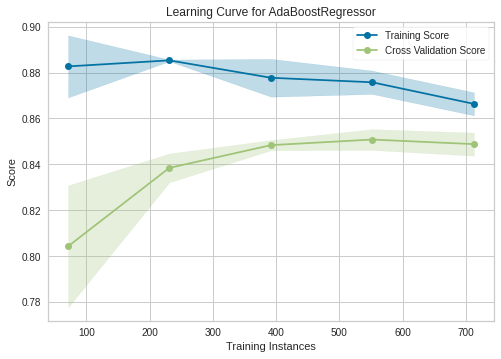

In [17]:
sizes = np.linspace(0.3, 1, 10)

visualizer = LearningCurve(
    exported_pipeline, scoring = 'r2', train_size = sizes, random_state = 101, cv = 3
)

visualizer.fit(X_train, y_train)
visualizer.show()

In [15]:
tpot.evaluated_individuals_

{'LinearSVR(Nystroem(input_matrix, Nystroem__gamma=0.25, Nystroem__kernel=chi2, Nystroem__n_components=10), LinearSVR__C=0.01, LinearSVR__dual=False, LinearSVR__epsilon=0.001, LinearSVR__loss=squared_epsilon_insensitive, LinearSVR__tol=0.01)': {'generation': 0,
  'mutation_count': 0,
  'crossover_count': 0,
  'predecessor': ('ROOT',),
  'operator_count': 2,
  'internal_cv_score': 0.31792720282566644},
 'XGBRegressor(LinearSVR(input_matrix, LinearSVR__C=5.0, LinearSVR__dual=True, LinearSVR__epsilon=1.0, LinearSVR__loss=epsilon_insensitive, LinearSVR__tol=1e-05), XGBRegressor__learning_rate=0.5, XGBRegressor__max_depth=10, XGBRegressor__min_child_weight=1, XGBRegressor__n_estimators=100, XGBRegressor__nthread=1, XGBRegressor__objective=reg:squarederror, XGBRegressor__subsample=0.5)': {'generation': 0,
  'mutation_count': 0,
  'crossover_count': 0,
  'predecessor': ('ROOT',),
  'operator_count': 2,
  'internal_cv_score': 0.7450880372408697},
 'RandomForestRegressor(MinMaxScaler(input_matr

> Di atas adalah evaluasi model-model yang sudah dilakukan